# Spencer Hallyburton
## Collaborator: Salvador Barragan

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 10
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import theano
from itertools import zip_longest
import itertools

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

Previous things:

In [2]:
# Read in the data and show it
iris = pd.read_csv('iris.csv')

# Convert the class to binary
class_vals = iris['class'].unique()
print(class_vals)
target_mapping = {
            class_vals[0]: 0,
            class_vals[1]: 0,
            class_vals[2]: 1}

iris['class'] = iris['class'].map(target_mapping)

# Augment data with a column of ones
iris.insert(0, 'ones', 1)
iris.head()

[' Iris-setosa' ' Iris-versicolor' ' Iris-virginica']


,ones,sepal_length,sepal_width,petal_length,petal_width,class
0,1,5.1,3.5,1.4,0.2,0
1,1,4.9,3.0,1.4,0.2,0
2,1,4.7,3.2,1.3,0.2,0
3,1,4.6,3.1,1.5,0.2,0
4,1,5.0,3.6,1.4,0.2,0


In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(iris.iloc[:,0:5], iris['class'], 
                                                    test_size=0.40, random_state=42)

In [4]:
# Construct a pymc3 model
sigma=10
with pm.Model() as iris_model:
    # Prior on beta
    beta = pm.Normal('beta', mu=0, sd=sigma, shape=X_train.shape[1])
    
    # Probabilities of each class
    p = pm.Deterministic('p', 1 / (1 + theano.tensor.exp(pm.math.dot(-X_train.values, beta))) )
    
    # Data likelihood
    obs_class = pm.Bernoulli('obs_class', p=p, observed=y_train.values)

In [5]:
map_estimate = pm.find_MAP(model=iris_model)

# Do the sampling
with iris_model:
    stepper = pm.NUTS()
    trace_iris = pm.sample(10000, step=stepper, start=map_estimate)

logp = -22.875, ||grad|| = 0.12477: 100%|██████████| 39/39 [00:00<00:00, 1039.06it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
100%|██████████| 10500/10500 [02:18<00:00, 75.88it/s]
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1201d5588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1202450b8>]], dtype=object)

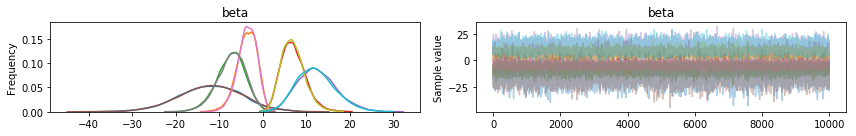

In [6]:
pm.traceplot(trace_iris, varnames=['beta'])

In [7]:
hm2df=pm.trace_to_dataframe(trace_iris, varnames=['beta'])
hm2df.corr()

,beta__0,beta__1,beta__2,beta__3,beta__4
beta__0,1.000000,-0.267572,-0.176278,-0.046967,-0.154698
beta__1,-0.267572,1.000000,-0.054265,-0.816913,-0.036895
beta__2,-0.176278,-0.054265,1.000000,-0.204887,-0.599163
beta__3,-0.046967,-0.816913,-0.204887,1.000000,-0.015344
beta__4,-0.154698,-0.036895,-0.599163,-0.015344,1.000000


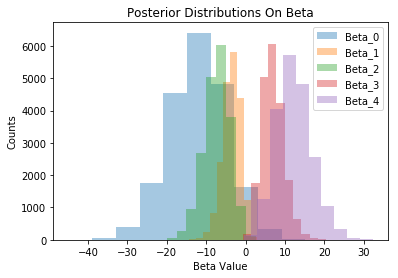

In [8]:
# Show beta posterior histograms
for n in range(trace_iris['beta'].shape[1]):
    plt.hist(trace_iris['beta'][:,n], alpha=0.4, label=r'Beta_%d'%n)
plt.legend()
plt.xlabel('Beta Value')
plt.ylabel('Counts')
plt.title('Posterior Distributions On Beta')
plt.show()

#### 1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?

In [9]:
# Let's look at pMean: calculate this using the posterior distribution
print(trace_iris['p'].shape)
post_means = trace_iris['p'].mean(axis=0)

(20000, 90)


In [10]:
# # Calculate pCDF over data points - fraction of points with values above 0.5
post_cdfs = sum(trace_iris['p'] > 0.5) / trace_iris['p'].shape[0]

In [11]:
# Calculate pp over data points using the predictive
with iris_model:
    ppc_samples = pm.sample_ppc(trace_iris, samples=2000)
    
# Get the pp estimate by taking the mean value across each data point
print(ppc_samples['obs_class'].shape)
pps = np.mean(ppc_samples['obs_class'], axis=0)

100%|██████████| 2000/2000 [00:00<00:00, 3311.86it/s]

(2000, 90)


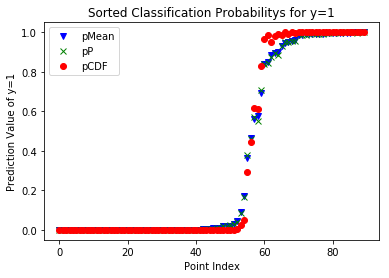

In [12]:
# Plot the distribution of values in a scatter plot sorted along the same sorting as the mean values
pmean, pcdf, pp = zip(*sorted(zip(post_means, post_cdfs, pps)))

# Plot the results in a scatter:
plt.plot(pmean, 'bv', label='pMean')
plt.plot(pp, 'gx', label='pP')
plt.plot(pcdf, 'ro', label='pCDF')
plt.xlabel('Point Index')
plt.ylabel('Prediction Value of y=1')
plt.title('Sorted Classification Probabilitys for y=1')
plt.legend()
plt.show()

In this first plot, we see the classification probabilities sorted on based on the ascending order of the pMean plot. This is the probability that a particular index is classified as a 1. We see that the structure of this classification is a logistic curve which matches our expectation based on the setup of our model initially.

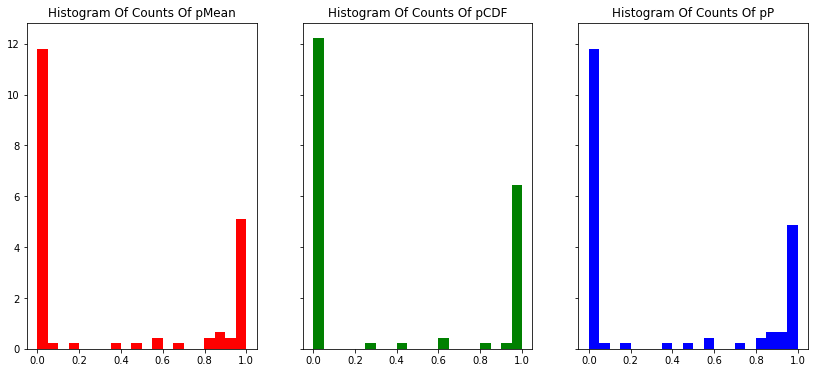

In [13]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(14,6))
labels = ['pMean', 'pCDF', 'pP']
clist = ['r','g','b']
# Plot the distribution of values in a histogram
for i, data in enumerate([post_means, post_cdfs, pps]):
    ax[i].hist(data, bins=20, normed=True, color=clist[i])
    ax[i].set_title('Histogram Of Counts Of %s' % labels[i])

plt.show()

**DIFFERENCES:**
In general, we see that all three instances have high occurrences of values either close to zero or close to 1. In terms of the differences, we see that the pMean and the posterior predictive have very similar behavior while hte pCDF has a slightly higher proportion at 0 or 1. This polarization towards 0 and 1 is not necessarily always the case, but given that the data appears to be highly separable along different characteristics, we expect this kind of behavior.

#### 2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

SEE BELOW IN PART 3 FOR THIS PLOT

In [14]:
# Along the trace of the posterior predictive, the fraction of misclassifications:
frac_miss_pp = 1 - sum(ppc_samples['obs_class']==y_train.values) / ppc_samples['obs_class'].shape[0]

#### 3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 


In [15]:
frac_miss_post = 1 - sum((trace_iris['p']>0.5)==y_train.values) / trace_iris['p'].shape[0]

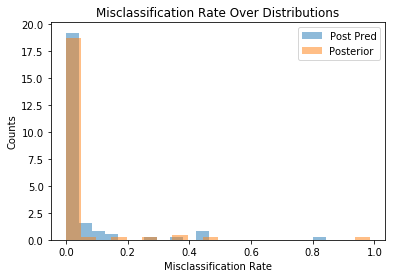

In [16]:
# Make a histogram of these over the data points
plt.hist(frac_miss_pp, normed=True, bins=20, alpha=0.5, label='Post Pred')
plt.hist(frac_miss_post, normed=True, bins=20, alpha=0.5, label='Posterior')
plt.xlabel('Misclassification Rate')
plt.ylabel('Counts')
plt.title('Misclassification Rate Over Distributions')
plt.legend()
plt.show()

According to the above plots, it seems that the posterior predictive has a wider misclassification rate than the posterior distribution. This matches our expectation because, even if it had the same mean rate, there is smearing that is associated with the sampling distribution for y. As a result, we expect that this distribution of error will be wider.

#### 4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.

In [17]:
# Compare rows of the posterior predictive traces to the true training labels
str_true = ''.join(str(x) for x in y_train.values)

str_array = []
for row in ppc_samples['obs_class']:
    str_array.append(''.join(str(x) for x in row))

In [18]:
# Number of times true row appears:
print('True String:', str_true)
print('Number of True Occurrences:', str_array.count(str_true))

# Get the mode:
str_mode = max(set(str_array), key=str_array.count)
print('\nMode Result:', str_mode)
print('Mode Occurrences:', str_array.count(str_mode))

# Get the edit distance between these two strings 
comp = [i for i in range(len(str_true)) if str_true[i]!=str_mode[i]]
print('\nEdit Distance Of True and Mode:', len(comp))

# Get the misclassification rate at these points
print('Misclass Rate At Difference:', frac_miss_pp[comp])

True String: 100000010010110010001000001000010110001100001011000101010100000000110011010011010011001001
Number of True Occurrences: 5

Mode Result: 100000010010110010001000001000011110001100011011000101010100000000110011010011010011001001
Mode Occurrences: 52

Edit Distance Of True and Mode: 2
Misclass Rate At Difference: [ 0.8445  0.46  ]


In this particular example, we see that the true labels string usually only appears a select few times. Occasionally, it does not appear at all! It is possible for this to change from test-to-test given the nature of sampling, however it does make some sense that it fails to appear based on the results of the misclassiciation rate analysis above. We saw that there were several points that had high misclassification rates throughout the posterior predictive samples. As a result, over the posterior predictives themselves, we do not expect to see an exact manifestation of the true label, given that we saw several high misclassification rates. We have printed their rates as 0.433, 0.8555, 0.455. As a result, there is a high chance that at least one of these points will be misclassified, thus preventing us from recovering the true string.

In calculating the edit distance of the two strings, we do see that the mode value is not too far off from the true label array, with only three place values different between the two of them.

#### 5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?

In [19]:
# Step 2: Posterior predictive misclassification rate on test
p_pred = 1/(1+np.exp(-X_test @ trace_iris['beta'].T)).T
y_pred = np.random.binomial(1, p_pred)

In [20]:
# Along the trace of the posterior predictive, the fraction of misclassifications:
frac_miss_post_2 = 1 - sum((p_pred>0.5)==y_test.values) / p_pred.shape[0]
frac_miss_pp_2 = 1 - sum(y_pred==y_test.values) / y_pred.shape[0]

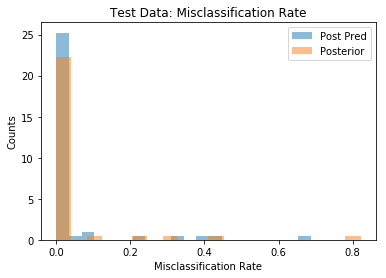

In [21]:
# Make a histogram of these over the data points
plt.hist(frac_miss_pp_2, normed=True, bins=20, alpha=0.5, label='Post Pred')
plt.hist(frac_miss_post_2, normed=True, bins=20, alpha=0.5, label='Posterior')
plt.xlabel('Misclassification Rate')
plt.ylabel('Counts')
plt.title('Test Data: Misclassification Rate')
plt.legend()
plt.show()

It appears in this plot that the width of the posterior predictive is not as large as it was in the previous case. The values appear to be more tight around the 0 misclassification rate. This is not to be expected, given that the model was trained on the trainging points, and, as a result, we expect it to perform more poorly on the test data.

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Long Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school
Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 


In [22]:
# Read in the data
census_data = pd.read_csv('census_data.csv')
census_data.head()

,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


In [23]:
# Process the gender data
sex_vals = census_data['sex'].unique()
print(sex_vals)
target_mapping_sex = {
            sex_vals[0]: 0,
            sex_vals[1]: 1}

# Process the earning data
earning_vals = census_data['earning'].unique()
print(earning_vals)
target_mapping_earn = {
            earning_vals[0]: 0, # <=50K
            earning_vals[1]: 1} # >50K

# Process the education data
edu_vals = census_data['edu'].unique()
print(edu_vals)
target_mapping_edu = {
            edu_vals[0]: 0, # Bachelors
            edu_vals[1]: 1, # HS-Grad
            edu_vals[2]: 2, # 11th
            edu_vals[3]: 3, # Masters
            edu_vals[4]: 4, # 9th
            edu_vals[5]: 5, # Some-college
            edu_vals[6]: 6, # Assoc-acdm
            edu_vals[7]: 7, # Assoc-voc
            edu_vals[8]: 8, # 7th-8th
            edu_vals[9]: 9, # Doctorate
            edu_vals[10]: 10, # Prof-school
            edu_vals[11]: 11, # 5th-6th
            edu_vals[12]: 12, # 10th
            edu_vals[13]: 13, # 1st-4th
            edu_vals[14]: 14, # Preschool
            edu_vals[15]: 15}# 12th


######################
census_data['sex'] = census_data['sex'].map(target_mapping_sex)
census_data['earning'] = census_data['earning'].map(target_mapping_earn)
census_data['edu'] = census_data['edu'].map(target_mapping_edu)

census_data.head()

['Male' 'Female']
['<=50K' '>50K']
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th' '1st-4th'
 'Preschool' '12th']


,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,0,Never-married,White,0,0
1,1,50,Self-emp-not-inc,0,Married-civ-spouse,White,0,0
2,2,38,Private,1,Divorced,White,0,0
3,3,53,Private,2,Married-civ-spouse,Black,0,0
4,4,28,Private,0,Married-civ-spouse,Black,1,0


In [24]:
# Aggregate the data into possible pairwise combinations
sexes = census_data['sex'].unique()
edus = census_data['edu'].unique()
earns = census_data['earning'].unique()
xgrid = [{'edu':[v[0]], 'sex':[v[1]]} for v in itertools.product(edus,sexes)]

In [25]:
# Loop over the grid parameters and aggregate the data
agg_data = pd.DataFrame()
for my_filter in xgrid: 
    tot = sum(census_data.isin(my_filter).sum(1) == len(my_filter.keys()))
    filter2 = my_filter.copy()
    filter2['earning'] = [1]
    hit = sum(census_data.isin(filter2).sum(1) == len(filter2.keys()))
    filter3 = my_filter.copy()
    filter3['<=50K'] = [tot-hit]
    filter3['>50K'] = [hit]
    filter3['total']= [tot]
    
    # Add data to dataframe:
    df2 = pd.DataFrame.from_dict(filter3)
    agg_data = agg_data.append(df2, ignore_index=True)

In [26]:
agg_data.head()

,<=50K,>50K,edu,sex,total
0,1854,1882,0,0,3736
1,1280,339,0,1,1619
2,5662,1449,1,0,7111
3,3164,226,1,1,3390
4,691,52,2,0,743


#### Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

From Example 10.1.3, our two models are:
1. A regression model that has admit as a function of gender
2. A regression model that has admit as a constant, ignoring gender

In [27]:
# Building the first model with gender
with pm.Model() as gender_model:
    alpha1 = pm.Normal('alpha', 0, 10)
    beta1 = pm.Normal('beta', 0, 10)
    logitpi1 = pm.Deterministic('logitpi', alpha1 + beta1*agg_data['sex']) 
    inc_binary1 = pm.Binomial('inc_binary', n=agg_data['total'] , p=pm.math.invlogit(logitpi1), observed=agg_data['>50K'])

In [28]:
# Sample the models
map1 = pm.find_MAP(model=gender_model)

with gender_model:
    stepper = pm.NUTS()
    traces1 = pm.sample(5000, step=stepper, start=map1)

logp = -7,636.9, ||grad|| = 9,429.7: 100%|██████████| 11/11 [00:00<00:00, 2146.02it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:04<00:00, 1288.42it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fa40be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f96f358>]], dtype=object)

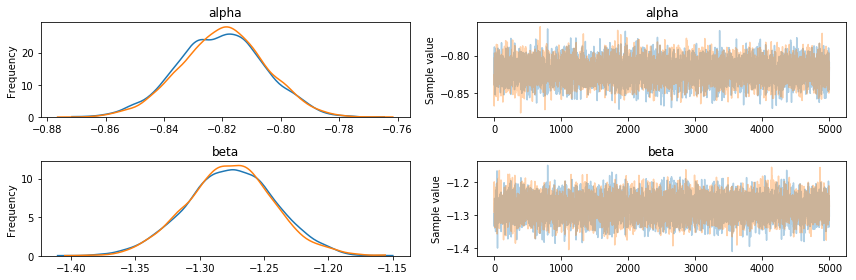

In [29]:
# Trace plots on this mode:
pm.traceplot(traces1, varnames=['alpha', 'beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fcd5588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1248256a0>]], dtype=object)

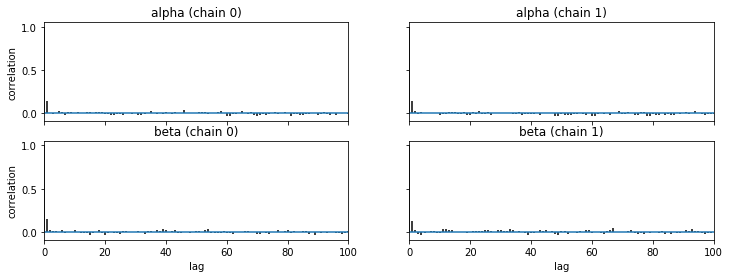

In [30]:
pm.autocorrplot(traces1, varnames=['alpha','beta'])

,alpha,beta
alpha,1.000000,-0.435898
beta,-0.435898,1.000000


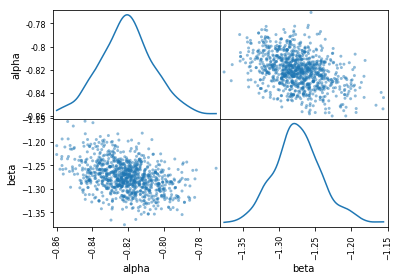

In [31]:
# Parameter trace correlation after burnin:
burn = 1000
df_trace=pm.trace_to_dataframe(traces1, varnames=['alpha','beta'])
pd.plotting.scatter_matrix(df_trace.iloc[-1000:,:], diagonal='kde')
df_trace.iloc[burn::,:].corr()

In [32]:
# Building the second model:
with pm.Model() as no_gender_model: 
    alpha2 = pm.Normal('alpha', 0, 10)
    logitpi2 = pm.Deterministic('logitpi', alpha2) 
    inc_binary2 = pm.Binomial('inc_binary', n=agg_data['total'] , p=pm.math.invlogit(logitpi2), observed=agg_data['>50K'])

In [33]:
# Sample model 2:
map2 = pm.find_MAP(model=no_gender_model)

with no_gender_model:
    stepper = pm.NUTS()
    traces2 = pm.sample(5000, step=stepper, start=map2)

logp = -7,633.7, ||grad|| = 8,439.5: 100%|██████████| 7/7 [00:00<00:00, 1352.88it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logitpi]
100%|██████████| 5500/5500 [00:02<00:00, 1963.75it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1260e8400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1262612e8>]], dtype=object)

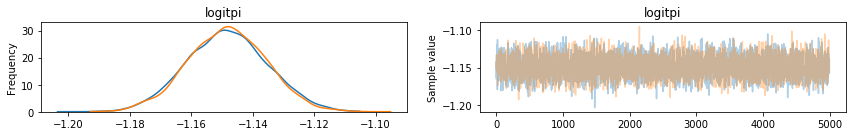

In [34]:
pm.traceplot(traces2, varnames=['logitpi'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126238780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11fc68b00>]], dtype=object)

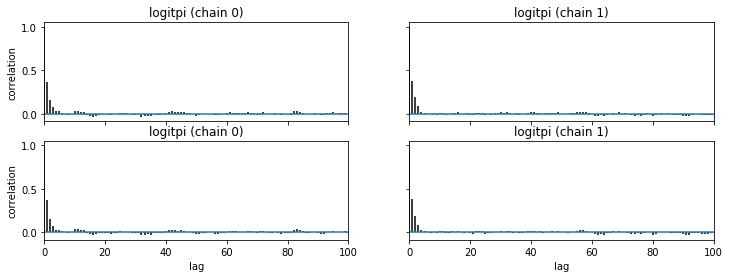

In [35]:
pm.autocorrplot(traces2)

#### Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

In [36]:
# Compute WAIC scores:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [37]:
names=['Gender Model', 'Non-Gender Model']
dfc=make_compare(names, [traces1, traces2],[gender_model, no_gender_model])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
Gender Model,4907.07,384.2,0,1,1143.27,0,1
Non-Gender Model,6512.33,339.1,1605.26,0,1875.05,1263.01,1


With the above results, we see that gender matters a lot in the determination of income. We see this from the fact that the WAIC is lower and the pWAIC is larger for the gendered model. We also see that the weight is 1.0 for the gender model. The dSE is not nearly enough to make up the different in the WAIC measurement. Now we should investigate to see where this different matters and make posterior samples.

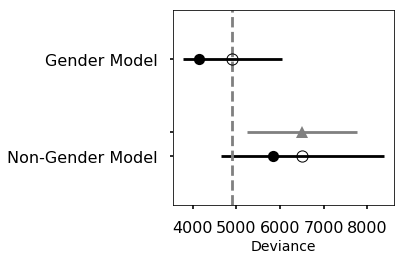

In [38]:
with sns.plotting_context('poster'):
    pm.compareplot(dfc)
    plt.tight_layout()

This description of the summary plot is found in the pymc3 documentation:

*The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC.*

*The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.*

*The filled black dots are the in-sample deviance of each model, which for WAIC is 2 pWAIC from the corresponding WAIC value.*

*For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.*

In [39]:
# Perform the posterior check
pct = [50-44.5, 50+44.5]
p_male = 1 / (1+np.exp(-traces1['alpha']))
p_exp_male = np.mean(p_male)
int_male = np.percentile(p_male, pct, axis=0)

p_female =  1 / (1+np.exp(-(traces1['alpha'] + traces1['beta'])))
p_exp_female = np.mean(p_female)
int_female = np.percentile(p_female, pct, axis=0)

In [40]:
# Check the posterior predictive
with gender_model:
    ppc1 = pm.sample_ppc(traces1, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 2568.64it/s]


In [41]:
quantiles = np.percentile(ppc1['inc_binary'], pct, axis=0)
quantiles = quantiles / agg_data['total'].values

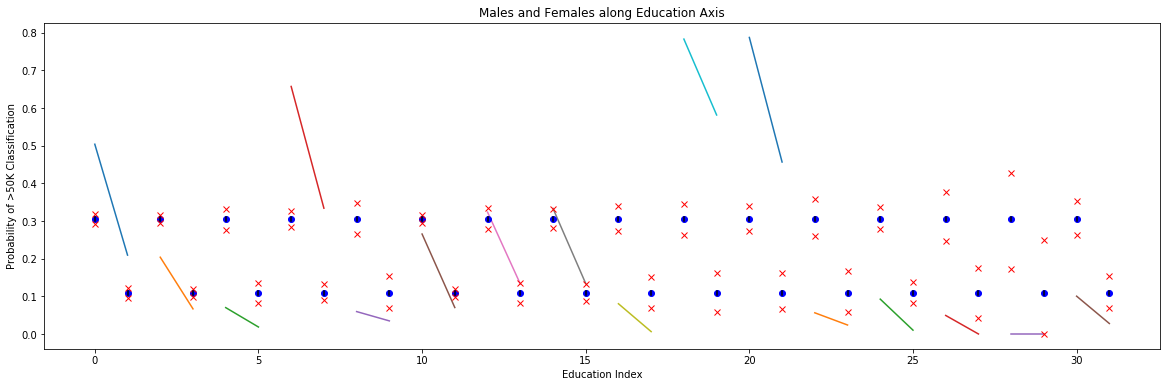

In [42]:
# Make a plot connecting lines from the different education levels from each gender
fig = plt.figure(figsize=(20,6))

for i in range(len(target_mapping_edu)):
    x = 2*i
    y1 = agg_data.loc[x,'>50K'] / agg_data.loc[x,'total']
    y2 = agg_data.loc[x+1,'>50K'] / agg_data.loc[x+1,'total']
    plt.plot([x, x+1], [y1,y2])
    plt.plot([x, x+1], [p_exp_male, p_exp_female], 'bo')
    plt.plot([x, x+1], [quantiles[:,2*i], quantiles[:,2*i+1]], 'rx')
    plt.plot([x, x], int_male, 'k')
    plt.plot([x+1, x+1], int_female, 'k')
plt.title('Males and Females along Education Axis')
plt.xlabel('Education Index')
plt.ylabel('Probability of >50K Classification')
plt.show()

In the above plot, we have made a made a model that depends only on gender and not on the education level. This is why we have a constant posterior and predictive across the education index. Across the board on the education axis, we see that the data show a decrease in the probability of earnings comparing men and women. We see that on some instances the blue and red are lower or higher on the probability axis than the actual data for that model. As a result, we see that, in order to recover the full trend of the model, we need to incorporate the education. We will do so in the next section.

#### Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education.

In [43]:
# Make an education-based model:

# Building the first model with gender
with pm.Model() as edu_gender_model:
    alpha = pm.Normal('alpha', 0, 10, shape=len(target_mapping_edu))
    beta = pm.Normal('beta', 0, 10)
    logitpi = pm.Deterministic('logitpi', alpha[agg_data['edu']] + beta*agg_data['sex']) 
    inc_binary = pm.Binomial('inc_binary', n=agg_data['total'] , p=pm.math.invlogit(logitpi), observed=agg_data['>50K'])

In [44]:
# Sample the models
map1 = pm.find_MAP(model=edu_gender_model)

with edu_gender_model:
    stepper = pm.NUTS()
    traces_edu_gender = pm.sample(5000, step=stepper, start=map1)

logp = -148.19, ||grad|| = 0.010272: 100%|██████████| 113/113 [00:00<00:00, 1576.95it/s] 
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:15<00:00, 351.98it/s]
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12716f8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12633c438>]], dtype=object)

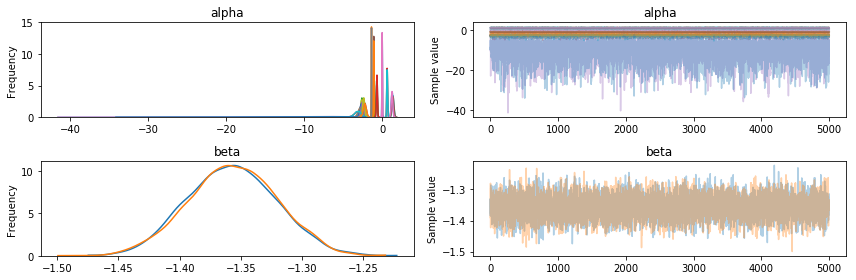

In [45]:
pm.traceplot(traces_edu_gender, varnames=['alpha', 'beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f982898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12700f080>]], dtype=object)

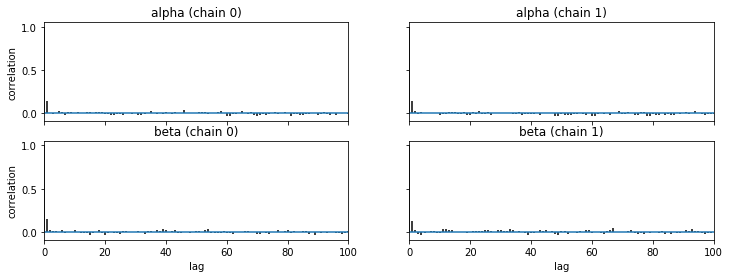

In [46]:
pm.autocorrplot(traces1, varnames=['alpha','beta'])

In [47]:
# Make an education-based model:

# Building the first model with gender
with pm.Model() as edu_no_gender_model:
    alpha = pm.Normal('alpha', 0, 10, shape=len(target_mapping_edu))
    logitpi = pm.Deterministic('logitpi', alpha[agg_data['edu']]) 
    inc_binary = pm.Binomial('inc_binary', n=agg_data['total'] , p=pm.math.invlogit(logitpi), observed=agg_data['>50K'])

In [48]:
# Sample the models
map1 = pm.find_MAP(model=edu_no_gender_model)

with edu_no_gender_model:
    stepper = pm.NUTS()
    traces_edu_no_gender = pm.sample(5000, step=stepper, start=map1)

logp = -974.78, ||grad|| = 0.067941: 100%|██████████| 87/87 [00:00<00:00, 1840.06it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 5500/5500 [00:08<00:00, 635.29it/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


#### Replicate the analysis in 10.1.3 using your models; specifically, compute WAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

In [49]:
# Compute WAIC scores:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [50]:
names=['Edu: Gender Model', 'Edu: Non-Gender Model']
dfc=make_compare(names, [traces_edu_gender, traces_edu_no_gender],[edu_gender_model, edu_no_gender_model])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
Edu: Gender Model,219.61,13.36,0,1,18.08,0,1
Edu: Non-Gender Model,2851.78,696.85,2632.17,0,765.88,753.83,1


In the above analysis, we see that gender makes an extremely large effect on the education-based model. In particular, we see that the difference in standard error of the WAIC scores is much less than the difference in the WAIC scores themselves. Additionally, the weight on the gender model is 1.0, indicating that gender plays a large role in the education model of incomes.

In [51]:
# Perform the posterior check
pct = [50-44.5, 50+44.5]
p_male = 1 / (1+np.exp(-traces_edu_gender['alpha']))
p_exp_male = np.mean(p_male,axis=0)
int_male = np.percentile(p_male, pct, axis=0)

p_female =  1 / (1+np.exp(-(traces_edu_gender['alpha'] + traces_edu_gender['beta'][:, np.newaxis])))
p_exp_female = np.mean(p_female,axis=0)
int_female = np.percentile(p_female, pct, axis=0)

In [52]:
# Check the posterior predictive
with edu_gender_model:
    ppc_eg = pm.sample_ppc(traces_edu_gender, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 2547.36it/s]


In [53]:
quantiles = np.percentile(ppc_eg['inc_binary'], pct, axis=0)
quantiles = quantiles / agg_data['total'].values

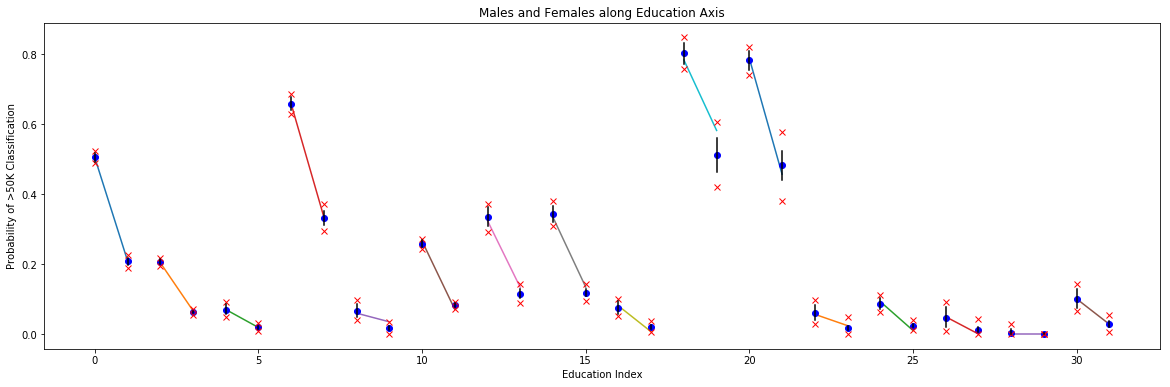

In [54]:
# Make a plot connecting lines from the different education levels from each gender
fig = plt.figure(figsize=(20,6))

for i in range(len(target_mapping_edu)):
    x = 2*i
    y1 = agg_data.loc[x,'>50K'] / agg_data.loc[x,'total']
    y2 = agg_data.loc[x+1,'>50K'] / agg_data.loc[x+1,'total']
    plt.plot([x, x+1], [y1,y2])
    plt.plot([x, x+1], [p_exp_male[i], p_exp_female[i]], 'bo')
    plt.plot([x, x+1], [quantiles[:,2*i], quantiles[:,2*i+1]], 'rx')
    plt.plot([x, x], int_male[:,i], 'k')
    plt.plot([x+1, x+1], int_female[:,i], 'k')
plt.title('Males and Females along Education Axis')
plt.xlabel('Education Index')
plt.ylabel('Probability of >50K Classification')
plt.show()

Above, we have generated the same plot as in the previous section, however, we have now included education into our model. We see that the posterior and posterior predictive match very well with the actual data in the model. This is to be expected, since we are grouping individuals based on their education index, and therefore, we expect to see large correlations between the groupins we have made.